shutil.copy() method in Python is used to copy the content of source file to destination file or directory
Syntax: shutil.copy(source, destination, *, follow_symlinks = True)

Dataset has been taken from here: https://github.com/ieee8023/covid-chestxray-dataset

In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, DenseNet201, ResNet101V2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Data

There are a few different views:

for X-rays:

- Posteroanterior (PA)
- Anteroposterior (AP)
- AP Supine (APS)
- Lateral (L)  

for CT scans:

- Axial
- Coronal 

https://github.com/ieee8023/covid-chestxray-dataset/blob/master/SCHEMA.md

# Building the Dataset

So far, I have 2 folders: images_covid That contains only covid x-rays, clean_data - contains only clean x-rays (from kaggle)


As the parameter in the constructor, it receives a path to the data. This parameter is used to create a so-called listed dataset. Essentially we utilize the list_files method from the tf.data.Dataset to load a list of all images from the given folder. This method uses pattern matching that is why we added ‘/*/*’ after the path to the data. The DataProcessor class has three private and one public method:

In [2]:
data_location = 'Desktop/covid_19/covid-chestxray-dataset-master/two_folders'
CLASS_NAMES = ['covid_data', 'clean_data']
IMAGE_SHAPE = (224, 224, 3)
BATCH_SIZE = 8
EPOCHS = 10
DATASET_SIZE = sum([len(files) for r, d, files in os.walk(data_location)])

In [3]:
from pathlib import Path
class DataProcessor():
    def __init__(self, data_location):
        #where_to_look = Path(f"{data_location}")
        #print(list(where_to_look.glob('./*/*')))
        #for file in where_to_look.iterdir():
           # print(file)
        self.labeled_dataset = tf.data.Dataset.list_files(f"{data_location}/*/*")
        
    # _get_label – Based on the location of the data this method extracts the label. 
    # In our case, the labels are ‘covid-19’ and ‘healthy’ because those are the folders 
    # that we have created. Also, we created CLASS_NAMES global, which contains the same information.
    
    def _get_label(self, file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        #print(parts[-2] == CLASS_NAMES)
        result = [0.0, 1.0]
        if parts[-2] == 'covid_data':
            result = [1.0, 0.0]
        return result
    
    # _decode_image – Loads image into memory and resize it. This is controlled by another global IMAGE_SHAPE. 
    # We use 256 x 256 size for each of the images, so we can help models to perform better.
    
    def _decode_image(self, img):
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return tf.image.resize(img, [IMAGE_SHAPE[0], IMAGE_SHAPE[1]])
    
    # _pre_proces_images – Utilizes previous methods and returns label and pre-processed image.
    
    def _pre_proces_images(self, file_path):
        #print(file_path)
        label = self._get_label(file_path)
        img = tf.io.read_file(file_path)
        img = self._decode_image(img)
        
        return img, label
    
    # prepare_dataset – This is the most important method of this class. 
    # Basically, this method loads all images and it’s label and creates a unified dataset from them. 
    # It also shuffles them and splits them into train, validation and test datasets.
    
    def prepare_dataset(self):
        #print("prepare dataset")
        self.labeled_dataset = self.labeled_dataset.map(self._pre_proces_images)
        self.labeled_dataset = self.labeled_dataset.cache()
        self.labeled_dataset = self.labeled_dataset.shuffle(buffer_size=DATASET_SIZE+1)
        self.labeled_dataset = self.labeled_dataset.repeat()
        self.labeled_dataset = self.labeled_dataset.batch(BATCH_SIZE)
        self.labeled_dataset = self.labeled_dataset.prefetch(buffer_size= tf.data.experimental.AUTOTUNE)
        
        train_size = int(0.7 * DATASET_SIZE)
        val_size = int(0.15 * DATASET_SIZE)
        test_size = int(0.15 * DATASET_SIZE)
        
        train_dataset = self.labeled_dataset.take(train_size)
        test_dataset = self.labeled_dataset.skip(train_size)
        val_dataset = test_dataset.skip(test_size)
        test_dataset = test_dataset.take(test_size)
        
        return train_dataset, test_dataset, val_dataset

In [4]:
# Finally, we can utilize this class like this:

processor = DataProcessor(data_location)
train_dataset, test_dataset, val_dataset = processor.prepare_dataset()
#for train_batch_img, train_batch_labels in test_dataset:
#    print(train_batch_labels[0])

As the output, we have prepared datasets ready to be processed by architectures we are about to create.

# Building and Training Models

Let’s start with the *Wrapper* class. This class is used to receive a **base model**, which we load from the TensorFlow, and **adds additional layers** on top of them. To be more clear, since large architectures are **hard** to train, TensorFlow provides a number of **pre-trained** models which you can use like VGG16, ResNet, DenseNet, etc. These models have calculated **weights** trained on the ImageNet dataset. However, the top layers of these models can be **removed**, and we can add layers that are necessary for our **specific** problems. That way we can utilize lower levels of these models, because on these levels networks detect features like straight line or curve, and at the same time change higher levels to detect specific features. Here is what the Wrapper class looks like:



In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf

IMAGE_SHAPE = (224, 224, 3)
BATCH_SIZE = 5
DATA_SET_SIZE = 3000
steps_per_epoch = DATASET_SIZE//BATCH_SIZE
validation_steps = 20
base_learning_rate = 0.0001

In [6]:
def create_resnet_model():
   
   pretrined_resnet = ResNet101V2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
   pretrined_resnet.trainable = False
   current_layer = pretrined_resnet.output
   current_layer = tf.keras.layers.AveragePooling2D()(current_layer)
   current_layer = tf.keras.layers.Flatten()(current_layer)
   current_layer = tf.keras.layers.Dense(64, activation="relu")(current_layer)
   current_layer = tf.keras.layers.Dropout(0.5)(current_layer)
   current_layer = tf.keras.layers.Dense(2, activation="softmax")(current_layer)
 
   our_model = tf.keras.models.Model(inputs=pretrined_resnet.input, outputs=current_layer)
 
   our_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                     loss='binary_crossentropy', metrics=['accuracy'])
   return our_model

In [7]:
def create_densenet_model():
    pretrined_densenet = DenseNet201(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
    pretrined_densenet.trainable = False
    dens_layer = pretrined_densenet.output
    dens_layer = tf.keras.layers.AveragePooling2D()(dens_layer)
    dens_layer = tf.keras.layers.Flatten()(dens_layer)
    dens_layer = tf.keras.layers.Dense(64, activation="relu")(dens_layer)
    dens_layer = tf.keras.layers.Dropout(0.5)(dens_layer)
    dens_layer = tf.keras.layers.Dense(2, activation="softmax")(dens_layer)
    
    dens_model = tf.keras.models.Model(inputs=pretrined_densenet.input, outputs=dens_layer)
    
    dens_model.compile(optimizer=Adam(lr=base_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return dens_model

In [8]:
def create_mobile_net_model():
    pretrined_mobile_net = MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
    pretrined_mobile_net.trainable = False
    mobile_net_layer = pretrined_mobile_net.output
    mobile_net_layer = tf.keras.layers.AveragePooling2D()(mobile_net_layer)
    mobile_net_layer = tf.keras.layers.Flatten()(mobile_net_layer)
    mobile_net_layer = tf.keras.layers.Dense(64, activation="relu")(mobile_net_layer)
    mobile_net_layer = tf.keras.layers.Dropout(0.5)(mobile_net_layer)
    mobile_net_layer = tf.keras.layers.Dense(2, activation="softmax")(mobile_net_layer)
    
    mobile_net_model = tf.keras.models.Model(inputs=pretrined_mobile_net.input, outputs=mobile_net_layer)
    
    mobile_net_model.compile(optimizer=Adam(lr=base_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return mobile_net_model

In [9]:
#class Wrapper(tf.keras.Model):
 #   def __init__(self, base_model):
  #      super(Wrapper, self).__init__()
   #     
    #    self.base_model = base_model
     #   self.average_pooling_layer = AveragePooling2D(name="polling")
      #  self.flatten = Flatten(name="flatten")
       # self.dense = Dense(64, activation="relu")
#        self.dropout = Dropout(0.5)
 #       self.output_layer = Dense(2, activation="softmax")
  #      
   # def call(self, inputs):
    #    x = self.base_model(inputs)
     #   x = self.average_pooling_layer(x)
      #  x = self.flatten(x)
      #  x = self.dense(x)
      #  x = self.dropout(x)
      #  output = self.output_layer(x)
      #  return output


In essence, it uses the passed pre-trained model (base_model) and adds Average Pooling, Flattening, Dropout and 2 Dense layers. Note that output is Dense layer with two nodes because we have two classes – covid-19 and healthy. Now we can load pre-trained models like this:

In [10]:
'''
base_learning_rate = 0.0001
steps_per_epoch = DATASET_SIZE//BATCH_SIZE
validation_steps = 20

mobile_net = MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
mobile_net.trainable = False
mobile = Wrapper(mobile_net)
mobile.compile(Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

res_net = ResNet101V2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
res_net.trainable = False
res = Wrapper(res_net)
res.compile(optimizer=Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

dense_net = DenseNet201(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
dense_net.trainable = False
dense = Wrapper(dense_net)
dense.compile(optimizer=Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
'''

"\nbase_learning_rate = 0.0001\nsteps_per_epoch = DATASET_SIZE//BATCH_SIZE\nvalidation_steps = 20\n\nmobile_net = MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')\nmobile_net.trainable = False\nmobile = Wrapper(mobile_net)\nmobile.compile(Adam(lr=base_learning_rate),\n              loss='binary_crossentropy',\n              metrics=['accuracy'])\n\nres_net = ResNet101V2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')\nres_net.trainable = False\nres = Wrapper(res_net)\nres.compile(optimizer=Adam(lr=base_learning_rate),\n              loss='binary_crossentropy',\n              metrics=['accuracy'])\n\ndense_net = DenseNet201(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')\ndense_net.trainable = False\ndense = Wrapper(dense_net)\ndense.compile(optimizer=Adam(lr=base_learning_rate),\n              loss='binary_crossentropy',\n              metrics=['accuracy'])\n"

We loaded and compiled **three architectures**: MobileNet, ResNet and DenseNet. Note that for each of these architectures we have set the trainable parameter to False, which means that base models are not trained during the training process, but **only** the additional layers we have added. Now we can run training for each of these models:

In [9]:
resnet = create_resnet_model()

In [10]:
history_resnet = resnet.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=validation_steps)

Train for 316 steps, validate for 20 steps
Epoch 1/10
316/316 [==============================] - 498s 2s/step - loss: 0.1235 - accuracy: 0.9545 - val_loss: 1.2490 - val_accuracy: 0.7437
Epoch 2/10
316/316 [==============================] - 454s 1s/step - loss: 0.0292 - accuracy: 0.9913 - val_loss: 1.7637 - val_accuracy: 0.7188
Epoch 3/10
316/316 [==============================] - 511s 2s/step - loss: 0.0181 - accuracy: 0.9925 - val_loss: 1.3402 - val_accuracy: 0.7625
Epoch 4/10
316/316 [==============================] - 658s 2s/step - loss: 0.0175 - accuracy: 0.9949 - val_loss: 0.3802 - val_accuracy: 0.8500
Epoch 5/10
316/316 [==============================] - 660s 2s/step - loss: 0.0053 - accuracy: 0.9980 - val_loss: 1.6129 - val_accuracy: 0.7000
Epoch 6/10
316/316 [==============================] - 656s 2s/step - loss: 0.0051 - accuracy: 0.9972 - val_loss: 1.8996 - val_accuracy: 0.6750
Epoch 7/10
316/316 [==============================] - 654s 2s/step - loss: 0.0025 - accuracy: 0.999

In [11]:
densenet = create_densenet_model()

In [12]:
history_densenet = densenet.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=validation_steps)

Train for 316 steps, validate for 20 steps
Epoch 1/10
316/316 [==============================] - 885s 3s/step - loss: 0.1413 - accuracy: 0.9411 - val_loss: 0.4003 - val_accuracy: 0.7750
Epoch 2/10
316/316 [==============================] - 753s 2s/step - loss: 0.0290 - accuracy: 0.9905 - val_loss: 0.2094 - val_accuracy: 0.8875
Epoch 3/10
316/316 [==============================] - 566s 2s/step - loss: 0.0165 - accuracy: 0.9968 - val_loss: 0.0769 - val_accuracy: 0.9625
Epoch 4/10
316/316 [==============================] - 636s 2s/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.1842 - val_accuracy: 0.9062
Epoch 5/10
316/316 [==============================] - 869s 3s/step - loss: 0.0083 - accuracy: 0.9972 - val_loss: 0.1208 - val_accuracy: 0.9438
Epoch 6/10
316/316 [==============================] - 874s 3s/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.3870 - val_accuracy: 0.8313
Epoch 7/10
316/316 [==============================] - 865s 3s/step - loss: 0.0086 - accuracy: 0.997

In [13]:
mobile_net = create_mobile_net_model()

In [14]:
history_mobile = mobile_net.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=validation_steps)

Train for 316 steps, validate for 20 steps
Epoch 1/10
316/316 [==============================] - 179s 567ms/step - loss: 0.1602 - accuracy: 0.9387 - val_loss: 0.2064 - val_accuracy: 0.9125
Epoch 2/10
316/316 [==============================] - 175s 554ms/step - loss: 0.0304 - accuracy: 0.9901 - val_loss: 0.1701 - val_accuracy: 0.9438
Epoch 3/10
316/316 [==============================] - 173s 548ms/step - loss: 0.0184 - accuracy: 0.9921 - val_loss: 0.2131 - val_accuracy: 0.9125
Epoch 4/10
316/316 [==============================] - 175s 552ms/step - loss: 0.0178 - accuracy: 0.9945 - val_loss: 0.0873 - val_accuracy: 0.9688
Epoch 5/10
316/316 [==============================] - 174s 552ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.1390 - val_accuracy: 0.9500
Epoch 6/10
316/316 [==============================] - 174s 552ms/step - loss: 0.0049 - accuracy: 0.9980 - val_loss: 0.1787 - val_accuracy: 0.9187
Epoch 7/10
316/316 [==============================] - 172s 545ms/step - loss: 0.0

# Ploting History

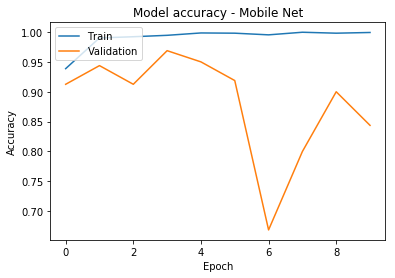

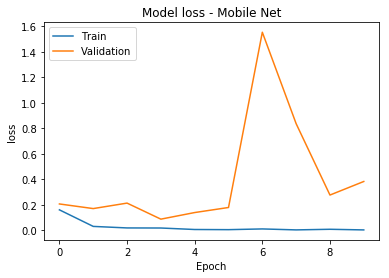

In [15]:
plt.plot(history_mobile.history['accuracy'])
plt.plot(history_mobile.history['val_accuracy'])
plt.title('Model accuracy - Mobile Net')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_mobile.history['loss'])
plt.plot(history_mobile.history['val_loss'])
plt.title('Model loss - Mobile Net')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


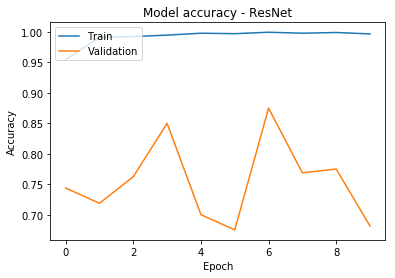

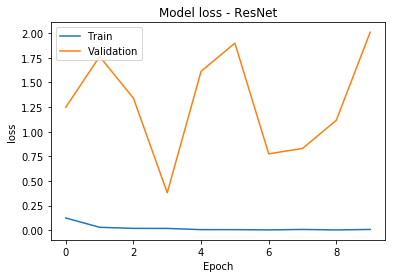

In [16]:
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Model accuracy - ResNet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('Model loss - ResNet')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

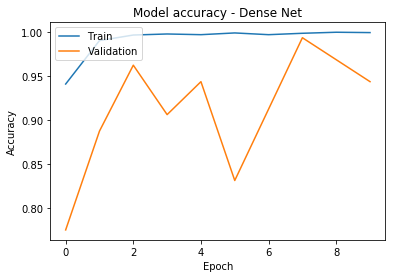

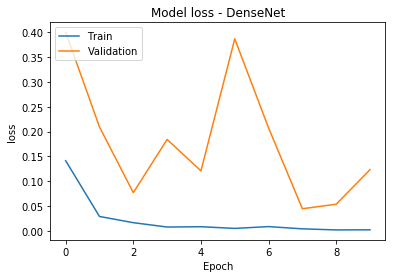

In [17]:
plt.plot(history_densenet.history['accuracy'])
plt.plot(history_densenet.history['val_accuracy'])
plt.title('Model accuracy - Dense Net')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_densenet.history['loss'])
plt.plot(history_densenet.history['val_loss'])
plt.title('Model loss - DenseNet')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluation

In [18]:
loss, accuracy = mobile_net.evaluate(test_dataset, steps = validation_steps)

print("--------MobileNet---------")
print("Loss: {:.2f}".format(loss))
print("Accuracy: {:.2f}".format(accuracy))
print("---------------------------")

20/20 [==============================] - 7s 328ms/step - loss: 0.5612 - accuracy: 0.8188
--------MobileNet---------
Loss: 0.56
Accuracy: 0.82
---------------------------


In [19]:
loss, accuracy = resnet.evaluate(test_dataset, steps = validation_steps)

print("--------ResNet---------")
print("Loss: {:.2f}".format(loss))
print("Accuracy: {:.2f}".format(accuracy))
print("---------------------------")

20/20 [==============================] - 35s 2s/step - loss: 2.0726 - accuracy: 0.6938
--------ResNet---------
Loss: 2.07
Accuracy: 0.69
---------------------------


In [20]:
loss, accuracy = densenet.evaluate(test_dataset, steps = validation_steps)

print("--------DenseNet---------")
print("Loss: {:.2f}".format(loss))
print("Accuracy: {:.2f}".format(accuracy))
print("---------------------------")

20/20 [==============================] - 36s 2s/step - loss: 0.0989 - accuracy: 0.9563
--------DenseNet---------
Loss: 0.10
Accuracy: 0.96
---------------------------


# Saving Models

In [22]:
tf.saved_model.save(mobile_net, './models_covid19/mobilenet/1')
tf.saved_model.save(resnet, './models_covid19/resnet/1')
tf.saved_model.save(densenet, './models_covid19/densenet/1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models_covid19/mobilenet/1/assets
INFO:tensorflow:Assets written to: ./models_covid19/resnet/1/assets
INFO:tensorflow:Assets written to: ./models_covid19/densenet/1/assets


In [23]:
mobile_net.save_weights('mobile_weights.h5')
resnet.save_weights('res_weights.h5')
densenet.save_weights('dense_weights.h5')